## Assignment 2 -  _Camera Trajectory Estimation_
**Grading details**

1. Find key points on an image (2 points).

2. Choose two consecutive images and match their keypoints (2 points).

3. Transfer detected keypoints coordinates to the real world coordinates (4 points).

4. Determine the translation vector and rotation matrix for the same 2 images using RANSAC. The partial code for this task is here (4 points)

5.  Find translation vectors and rotation matrices for all pairs of consecutive images (2 points)

6. Skip an image if it creates a bad translation vector (2 points)

7. Convert all translations vectors to the coordinate system of the first image (1 point)

8. Draw the camera trajectory with a view from above (1 point)

9. Draw the camera trajectory on the first image (2 points)


**Additional notes**

- SIFT is a proprietary algorithm not shipped with the standard `opencv-python` library. In order to use it uninstall `opencv-python` and install `opencv-contrib-python`: `pip install opencv-contrib-python==3.4.0.14`.

- To translate coordinates between the world coordinate space (x,y,z) and the camera coordinate space (u, v in pixels), you may refer to https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html (Links to an external site.)

- You will need the matrix of the camera's intrinsic parameters. It's saved in the file camera_matrix.json

- The depth images are single-channel 16 bit. Every pixel contains the depth in millimeters to the corresponding point. To read it, use OpenCV imread with the flag IMREAD_UNCHANGED.

- Take a look at several depth images. Sometimes they are noisy since the camera wasn't able to compute depth at certain points. The right way to estimate camera displacement is to ignore these points. 

- We found the image number 740 to be blurred, and it spoiled our algorithm. We recommend you to ignore this image in your code. Also, you may ignore the first 100 images if you find this useful.


**Important NOTE!**

- To make your life less painfull, place this jupyter notebook in to a directory with the folder `captured` - in which images images are saved


In [19]:
from numba import jit

@jit
def rigid_transform_3d(xs,ys):
    """
    expects 2 arrays of shape (3, N)

    rigid transform algorithm from
    http://nghiaho.com/?page_id=671
    """
    assert xs.shape == ys.shape
    assert xs.shape[0] == 3, 'The points must be of dimmensionality 3'

    # find centroids and H
    x_centroid = np.mean(xs, axis=1)[:, np.newaxis]
    y_centroid = np.mean(ys, axis=1)[:, np.newaxis]
    
    H = (xs - x_centroid)@(ys - y_centroid).T

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    rotation = Vt.T@U.T

    # handling reflection
    if np.linalg.det(rotation) < 0:
        Vt[2, :] *= -1
        rotation = np.dot(Vt.T, U.T)
    
    # find translation
    translation = y_centroid - rotation@x_centroid
    
    return translation, rotation  



In [2]:
class Translation:
    def __init__(self):
        self.R = np.eye(3)
        self.t = np.zeros(3)

    def estimate(self, src, dst):
        self.t, self.R = rigid_transform_3d(src.T, dst.T)

    def residuals(self, src, dst):
        residuals = []
        for p1, p2 in zip(src, dst):
            diff = np.dot(self.R, p1) + self.t - p2
            residuals.append(np.linalg.norm(diff))

        return np.array(residuals)

**1. Find key points on an image (2 points).**


Sevaral key point extractors have been tested to see which one of them performes better. `ORB` key point extractor was used  in the course of this homework.
    

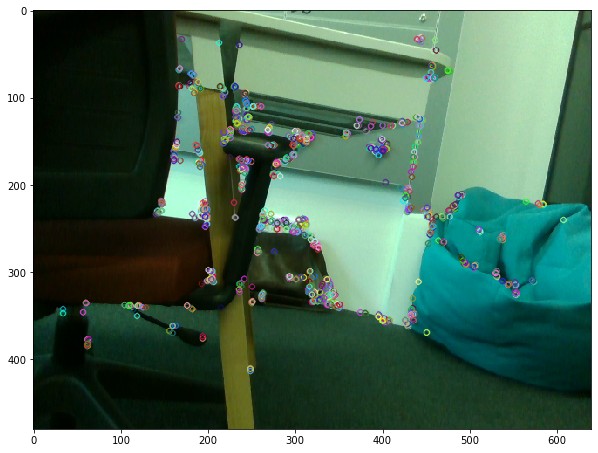

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imageA = cv2.imread('captured\color_3.png',cv2.IMREAD_UNCHANGED)
orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(imageA, None)

plt.figure(figsize=(10,10))
img = cv2.drawKeypoints(imageA, keypoints_orb, None)
plt.imshow(img)


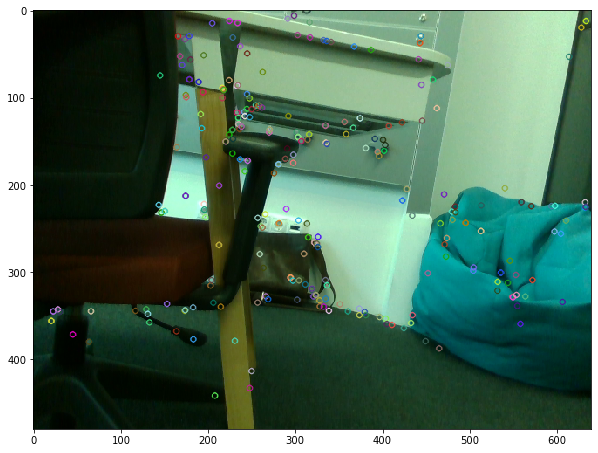

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


imageA = cv2.imread('captured\color_3.png',cv2.IMREAD_UNCHANGED)

sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()

keypoints_sift, descriptors = sift.detectAndCompute(imageA, None)
keypoints_surf, descriptors = surf.detectAndCompute(imageA, None)
keypoints_orb, descriptors = orb.detectAndCompute(imageA, None)

plt.figure(figsize=(10,10))
img = cv2.drawKeypoints(imageA, keypoints_sift, None)
plt.imshow(img)

**2. Choose two consecutive images and match their keypoints (2 points).**

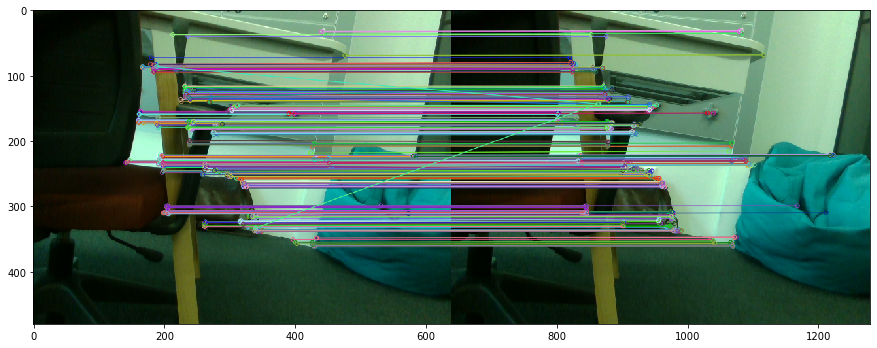

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imageA = cv2.imread('captured\color_3.png',cv2.IMREAD_UNCHANGED)
imageB = cv2.imread('captured\color_4.png',cv2.IMREAD_UNCHANGED)
depthA = cv2.imread('captured\depth3.png',cv2.IMREAD_UNCHANGED)
depthB = cv2.imread('captured\depth4.png',cv2.IMREAD_UNCHANGED)

# ORB Detector
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imageA, None)
kp2, des2 = orb.detectAndCompute(imageB, None)

# Brute Force Matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

matching_result = cv2.drawMatches(imageA, kp1, imageB, kp2, matches, None, flags=2)


plt.figure(figsize=(15,15))
plt.imshow(matching_result)


**3.Transfer detected keypoints coordinates to the real world coordinates (4 points).**

In [6]:
def to_real(x,y,z):
    A = np.asarray([[612.0, 0.0, 328.467896], [0.0, 612.0, 247.233337], [0.0, 0.0, 1.0]])
    return (z*np.linalg.inv(A)@np.asarray([x,y,1]))

In [7]:
x, y = kp1[1].pt
z = depthA[int(y),int(x)]
print(to_real(x,y,z))

[  45.48290511  305.07683953 2057.        ]


**4. Determine the translation vector and rotation matrix for the same 2 images using RANSAC. The partial code for this task is here (4 points)**

In [8]:

def matchgen(n):
    
    imageA = cv2.imread('captured\color_'+str(n)+'.png',cv2.IMREAD_UNCHANGED)
    imageB = cv2.imread('captured\color_'+str(n+1)+'.png',cv2.IMREAD_UNCHANGED)
    depthA = cv2.imread('captured\depth'+str(n)+'.png',cv2.IMREAD_UNCHANGED)
    depthB = cv2.imread('captured\depth'+str(n+1)+'.png',cv2.IMREAD_UNCHANGED)

    # ORB Detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(imageA, None)
    kp2, des2 = orb.detectAndCompute(imageB, None)

    # Brute Force Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    setA,setB = [],[]
    for match in matches[:100]:
        
        xa,ya = kp1[match.queryIdx].pt
        xb,yb = kp2[match.trainIdx].pt
        za = depthA[int(ya),int(xa)]
        zb = depthB[int(yb),int(xb)]
    
        if za!=0 and zb!=0:
            setA.append(list(map(int,to_real(xa,ya,za))))
            setB.append(list(map(int,to_real(xb,yb,zb))))

    return np.asarray(setA),np.asarray(setB)

In [9]:
from skimage.measure import ransac

SetA,SetB = matchgen(100)

R,t = ransac((SetA,SetB),
             Translation,
             min_samples=10,
             residual_threshold=100
            )
R.R

array([[ 9.99915454e-01, -1.29728707e-02, -8.88033766e-04],
       [ 1.29787492e-02,  9.99891485e-01,  6.96919727e-03],
       [ 7.97526906e-04, -6.98013363e-03,  9.99975321e-01]])

In [10]:
R.t

array([[ 11.48835869],
       [-12.35363306],
       [-10.84634549]])

**5. Find translation vectors and rotation matrices for all pairs of consecutive images (2 points)**

In [17]:
from tqdm import tqdm_notebook

Rotation = []
Translat = []
count = 0

startFrame = 100
endFrame = 1090
#last image is 1093
for n in tqdm_notebook(range(startFrame,endFrame)):

    try:
        
        SetA,SetB = matchgen(n)
        R,t = ransac((SetA,SetB),
                     Translation,
                     min_samples=10,
                     residual_threshold=100
                    )

        if np.linalg.norm(R.t) < 50:
            Rotation.append(R.R)
            Translat.append(R.t)
        
        
    except:
        print("Did not work this time")
        count += 1
#     print('Ration matrix: \n {} \n {}'.format(R,t))
Rotation = np.array(Rotation)
Translat = np.array(Translat)

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


**6. Skip an image if it creates a bad translation vector (2 points)**

Here, I look for `norms` of traslation vectors and if a norm of a vector exceeds $50$, I donot count that vector in calculations. The value $50$ had been selected by triel and error method by plotting all the norms and seeing outliers. Outliers' norms are well above $50$. See the implementation skip mechanism in the loop above!

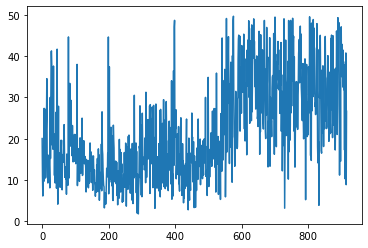

In [18]:
norms = [np.linalg.norm(i) for i in Translat]
plt.plot(range(len(norms)), norms)

**7. Convert all translations vectors to the coordinate system of the first image (1 point)**


In [12]:
Fullrotation= np.eye(3)
TransInCrdnt = []

for i in range(len(Rotation)):
    
    TransInCrdnt.append( Fullrotation@Translat[i].copy() )
#     Fullrotation = np.linalg.inv(Rotation[i].copy())@Fullrotation
    Fullrotation = Fullrotation@np.linalg.inv(Rotation[i].copy())
    
TransInCrdnt = np.squeeze( np.array(TransInCrdnt) )
TransInCrdnt.shape


(915, 3)

**8. Draw the camera trajectory with a view from above (1 point)**

In [13]:
traj = []
summ = np.array([0.,0.,0.])

for i in range(TransInCrdnt.shape[0]):
    traj.append(summ)
    summ = summ + TransInCrdnt[i]
    
traj = np.array(traj)
traj.shape

(915, 3)

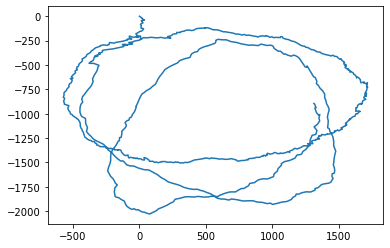

In [14]:
plt.plot(traj[:,0], traj[:,2])

**9. Draw the camera trajectory on the first image (2 points)**


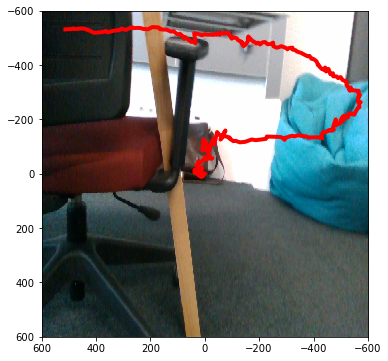

In [15]:
plt.figure(figsize=(9,6))
plt.imshow( cv2.imread('captured\color_100.png',cv2.IMREAD_UNCHANGED), extent=[600, -600, 600, -600])
plt.plot(traj[:250,0], -1*traj[:250,1],linewidth=4,c='red')

In [17]:
traj.shape

(915, 3)

In [52]:
A = np.asarray([[612.0, 0.0, 328.467896], [0.0, 612.0, 247.233337], [0.0, 0.0, 1.0]])
camtraj = (A@traj.T).T

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


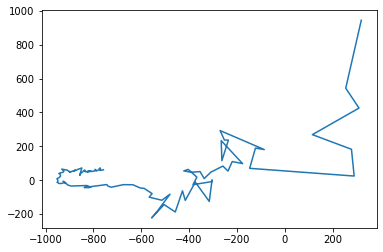

In [53]:
plt.plot(-1*camtraj[:100,0],camtraj[:100,1])

In [34]:
camtraj.shape

(3, 915)